# Superstore EDA and RFM Segmentation with K-Means

This notebook walks through the step-by-step process of performing **RFM (Recency, Frequency, Monetary)** analysis and applying **K-Means clustering** to group customers based on their purchasing behaviour.

The goal is to identify customer segments to support marketing and business strategies.

---

### Analysis Performed in This Project:
1. Loaded and merged customer, order, and transaction data  
2. Calculated RFM values for each customer  
3. Normalized features and applied K-Means clustering  
4. Assigned customers to segments and visualised the results  
5. Exported the final dataset for reporting or dashboard use

Use this notebook to explore how unsupervised learning can unlock business value from transactional data.

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

### Step 1: Load and Merge Raw Data

We begin by loading the four CSV files: `customers`, `products`, `orders`, and `order_details`.  
Then we merge them to get a single dataset that includes order dates, sales values, and customer IDs.

In [2]:
import pandas as pd

# Load individual datasets
customers = pd.read_csv("customers.csv")
products = pd.read_csv("products.csv")
orders = pd.read_csv("orders.csv", parse_dates=["Order Date"])
order_details = pd.read_csv("order_details.csv")

# Merge orders with order_details
df = pd.merge(orders, order_details, on="Order ID")

# Merge with customers to get Customer ID and Segment details
df = pd.merge(df, customers, on="Customer ID")

# Preview the merged dataset
df.head()

,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit,Customer Name,Segment,Country,Region
0,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-BO-10001798,261.96,2.0,0.0,41.91,Claire Gute,Consumer,United States,South
1,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-BO-10001798,261.96,2.0,0.0,41.91,Claire Gute,Consumer,United States,Central
2,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-CH-10000454,731.94,3.0,0.0,219.58,Claire Gute,Consumer,United States,South
3,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-CH-10000454,731.94,3.0,0.0,219.58,Claire Gute,Consumer,United States,Central
4,CA-2016-138688,06-12-2016,6/16/2016,Second Class,DV-13045,OFF-LA-10000240,14.62,2.0,0.0,6.87,Darrin Van Huff,Corporate,United States,West


### Step 1.1: Exploratory Data Analysis (EDA)

Before building the RFM model, we perform basic Exploratory Data Analysis (EDA) to understand the structure and quality of the dataset.

This includes:
- Checking for missing values or duplicates
- Viewing column types and summary statistics
- Plotting distributions to identify skewness or outliers

In [3]:
# Check shape and preview data
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (33496, 14)


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Product ID,Sales,Quantity,Discount,Profit,Customer Name,Segment,Country,Region
0,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-BO-10001798,261.96,2.0,0.0,41.91,Claire Gute,Consumer,United States,South
1,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-BO-10001798,261.96,2.0,0.0,41.91,Claire Gute,Consumer,United States,Central
2,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-CH-10000454,731.94,3.0,0.0,219.58,Claire Gute,Consumer,United States,South
3,CA-2016-152156,11-08-2016,11-11-2016,Second Class,CG-12520,FUR-CH-10000454,731.94,3.0,0.0,219.58,Claire Gute,Consumer,United States,Central
4,CA-2016-138688,06-12-2016,6/16/2016,Second Class,DV-13045,OFF-LA-10000240,14.62,2.0,0.0,6.87,Darrin Van Huff,Corporate,United States,West


In [4]:
# Check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33496 entries, 0 to 33495
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Order ID       33496 non-null  object 
 1   Order Date     33496 non-null  object 
 2   Ship Date      33496 non-null  object 
 3   Ship Mode      33496 non-null  object 
 4   Customer ID    33496 non-null  object 
 5   Product ID     33496 non-null  object 
 6   Sales          33496 non-null  float64
 7   Quantity       33496 non-null  float64
 8   Discount       33496 non-null  float64
 9   Profit         33496 non-null  float64
 10  Customer Name  33496 non-null  object 
 11  Segment        33496 non-null  object 
 12  Country        33496 non-null  object 
 13  Region         33496 non-null  object 
dtypes: float64(4), object(10)
memory usage: 3.6+ MB


In [5]:
# Check null values
df.isnull().sum()

Order ID         0
Order Date       0
Ship Date        0
Ship Mode        0
Customer ID      0
Product ID       0
Sales            0
Quantity         0
Discount         0
Profit           0
Customer Name    0
Segment          0
Country          0
Region           0
dtype: int64

In [6]:
# Check for duplicate records
print("\nDuplicate rows:", df.duplicated().sum())


Duplicate rows: 0


In [7]:
# Summary statistics
df.describe()

,Sales,Quantity,Discount,Profit
count,33496.000000,33496.000000,33496.000000,33496.000000
mean,231.485955,3.794692,0.158013,29.083233
std,639.227281,2.230561,0.208287,240.065893
min,0.440000,1.000000,0.000000,-6599.980000
25%,17.180000,2.000000,0.000000,1.680000
50%,54.340000,3.000000,0.200000,8.530000
75%,209.970000,5.000000,0.200000,29.360000
max,22638.480000,14.000000,0.800000,8399.980000


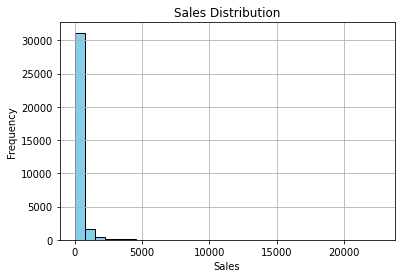

In [8]:
# Distribution of Sales
plt.figure(figsize=(6, 4))
plt.hist(df["Sales"], bins=30, color='skyblue', edgecolor='black')
plt.title("Sales Distribution")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

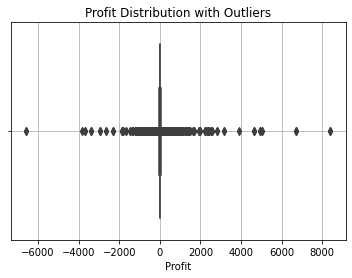

In [9]:
# Boxplot for Profit to identify outliers
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["Profit"])
plt.title("Profit Distribution with Outliers")
plt.xlabel("Profit")
plt.grid(True)
plt.show()

#### Interpretation of Sales and Profit Distributions

- **Sales Distribution**: The histogram is right-skewed, with most transactions having low sales values. A small number of transactions contribute to very high sales, suggesting the presence of high-value orders that may influence average metrics.


- **Profit Distribution**: The boxplot shows a high number of outliers on both sides. While many transactions have moderate profits, there are significant losses and extreme positive profits. This implies that some products or customers may be consistently unprofitable.

These patterns support the importance of segmentation, understanding who the most profitable and at-risk customers are, rather than relying on averages.

### EDA Summary

The exploratory data analysis provided key insights into the structure and behaviour of the dataset:

- **No missing or duplicate values** were found in the merged dataset.
- **Sales values** are right-skewed, indicating that a small number of orders contribute to most of the revenue.
- **Profit data** contains significant outliers, including some extreme losses, highlighting the need for deeper profitability analysis.

This EDA reinforces the value of performing RFM analysis and clustering to identify customer groups and tailor business strategies.


### Step 2: Calculate RFM Metrics

RFM (Recency, Frequency, Monetary) analysis helps understand customer behaviour:
- **Recency**: Days since the last purchase
- **Frequency**: Total number of purchases
- **Monetary**: Total amount spent

We'll group by Customer ID and calculate each metric.

In [10]:
# Make sure 'Order Date' is in date format
df["Order Date"] = pd.to_datetime(df["Order Date"], format='mixed', dayfirst=True, errors='coerce')

# Set a fixed date for our analysis (one day after last purchase)
fixed_date = df["Order Date"].max() + pd.Timedelta(days=1)

# Create a new RFM table grouped by Customer ID
rfm = df.groupby("Customer ID").agg(
    Recency=("Order Date", lambda x: (fixed_date - x.max()).days),
    Frequency=("Order ID", "nunique"),
    Monetary=("Sales", "sum")
).reset_index()

# Show the first 5 rows
rfm.head()

,Customer ID,Recency,Frequency,Monetary
0,AA-10315,185,5,16690.68
1,AA-10375,49,9,4225.56
2,AA-10480,260,4,5371.53
3,AA-10645,234,6,20347.76
4,AB-10015,446,3,1772.30


### Explore Correlation Between RFM Features

Before applying clustering, we analyse the relationship between Recency, Frequency, and Monetary values using a correlation heatmap.

This helps us understand:
- Which features are positively or negatively related
- Whether any features might be redundant
- How customer behaviour dimensions interact

This visual also supports better interpretation of cluster characteristics later in the analysis.

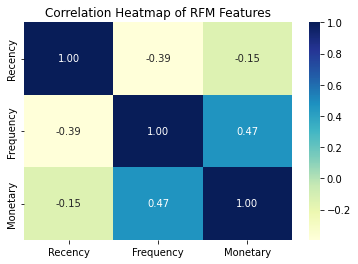

In [11]:
# Calculate correlation matrix for RFM features
rfm_corr = rfm[["Recency", "Frequency", "Monetary"]].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(rfm_corr, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap of RFM Features")
plt.show()

#### Interpretation of the Correlation Heatmap

From the correlation heatmap:

- **Frequency and Monetary** have a moderate positive correlation (0.47), which suggests that customers who purchase more frequently tend to spend more, though it's not a perfect relationship.
- **Recency** shows a **negative correlation** with both Frequency (-0.39) and Monetary (-0.15). This is expected, since customers who purchased more recently (low Recency values) are often more active and valuable.
- The low-to-moderate strength of these correlations confirms that all three RFM variables capture **distinct dimensions** of customer behaviour.

This justifies including all three features in the clustering model, as they are not redundant and each contributes unique information.


### Step 3: Normalize RFM Values and Apply K-Means Clustering

RFM features have different ranges. To apply clustering, we first scale them using StandardScaler so that each value contributes equally.

Then we use K-Means to segment customers into groups with similar buying behavior.

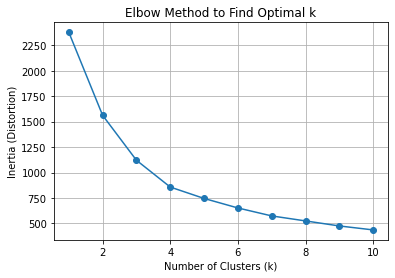

In [12]:
# Extract RFM values only
rfm_values = rfm[["Recency", "Frequency", "Monetary"]]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_values)

# Use the Elbow method to find the best number of clusters
inertia = []
for k in range(1, 11):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(rfm_scaled)
    inertia.append(model.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method to Find Optimal k")
plt.grid(True)
plt.show()

### Step 4: Fit K-Means Model and Assign Segments

We apply K-Means clustering to group customers based on their Recency, Frequency, and Monetary values. Each customer will be assigned to a segment (cluster).

In [13]:
# Step 1: Import and fit K-Means with your chosen k (e.g., 4)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(rfm_scaled)

# Step 2: Add the cluster labels to the original RFM table
rfm["Cluster"] = kmeans.labels_

# Step 3: View the updated table
rfm.head()

,Customer ID,Recency,Frequency,Monetary,Cluster
0,AA-10315,185,5,16690.68,2
1,AA-10375,49,9,4225.56,1
2,AA-10480,260,4,5371.53,2
3,AA-10645,234,6,20347.76,1
4,AB-10015,446,3,1772.30,0


In [14]:
# Preview cluster sizes
rfm["Cluster"].value_counts().sort_index()

Cluster
0     92
1    302
2    327
3     72
Name: count, dtype: int64

### Step 5: Visualise and Interpret Customer Segments

We'll now plot the clusters using 2D scatter plots to understand the characteristics of each group. This helps us give business-friendly labels like:
- Loyal Customers
- New Customers
- At-Risk
- High Value

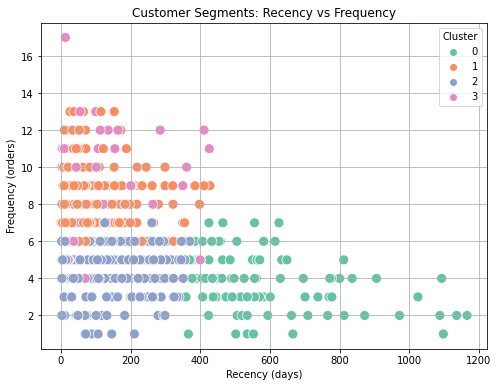

In [15]:
# Plot Recency vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x="Recency", y="Frequency", hue="Cluster", palette="Set2", s=100)
plt.title("Customer Segments: Recency vs Frequency")
plt.xlabel("Recency (days)")
plt.ylabel("Frequency (orders)")
plt.grid(True)
plt.show()

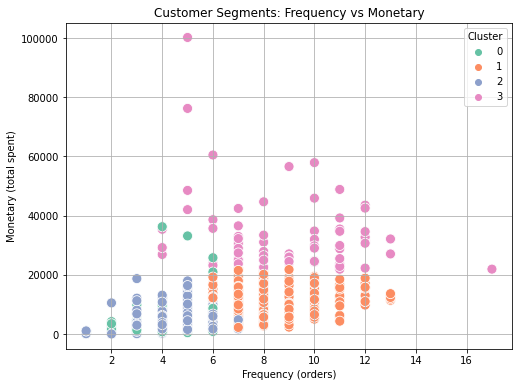

In [16]:
# Plot Monetary vs Frequency
plt.figure(figsize=(8, 6))
sns.scatterplot(data=rfm, x="Frequency", y="Monetary", hue="Cluster", palette="Set2", s=100)
plt.title("Customer Segments: Frequency vs Monetary")
plt.xlabel("Frequency (orders)")
plt.ylabel("Monetary (total spent)")
plt.grid(True)
plt.show()

### How do we know which cluster is which?
- We don’t know the labels automatically. KMeans just gives us cluster numbers (0, 1, 2, etc.) based on math, not meaning.
- That’s why we need to manually interpret what each cluster represents based on their average RFM values.

In [17]:
# Show average Recency, Frequency, and Monetary by cluster
rfm.groupby("Cluster")[["Recency", "Frequency", "Monetary"]].mean().round(1)

,Recency,Frequency,Monetary
Cluster,,,
0,585.5,3.8,5136.3
1,86.2,8.4,10918.2
2,129.4,4.6,4913.2
3,113.4,8.8,33019.7


### Step 6:Label the Customer Segments

Now that we've assigned each customer to a cluster using K-Means, we'll interpret the clusters based on their average Recency, Frequency, and Monetary values.

Using this analysis:
- **Cluster 0** has very high Recency and low Frequency — these are **Lost Customers**
- **Cluster 1** shows active behavior with good Frequency and spend — these are **Engaged Customers**
- **Cluster 2** has moderate values but high Recency — these are **At Risk**
- **Cluster 3** has the highest Frequency and Monetary spend — these are our **High Value Loyalists**

We map each cluster number to a meaningful business label to make the results easier to understand and use.

In [18]:
cluster_labels = {
    0: "Lost Customers",
    1: "Engaged Customers",
    2: "At Risk",
    3: "High Value Loyalists"
}

rfm["Segment"] = rfm["Cluster"].map(cluster_labels)

# Preview the result
rfm[["Customer ID", "Recency", "Frequency", "Monetary", "Cluster", "Segment"]].head()

,Customer ID,Recency,Frequency,Monetary,Cluster,Segment
0,AA-10315,185,5,16690.68,2,At Risk
1,AA-10375,49,9,4225.56,1,Engaged Customers
2,AA-10480,260,4,5371.53,2,At Risk
3,AA-10645,234,6,20347.76,1,Engaged Customers
4,AB-10015,446,3,1772.30,0,Lost Customers


### Final Output: Customer Segments with RFM Scores


Each customer is now assigned to:
- A **Cluster** number (generated by the K-Means model)
- A **Segment** label (translated into meaningful business categories)

| Segment               | Description                                          |
|-----------------------|------------------------------------------------------|
| High Value Loyalists  | Frequent, high-spending, and recently active        |
| Engaged Customers     | Fairly active and valuable, good retention potential |
| At Risk               | Haven't purchased in a while, moderate value        |
| Lost Customers        | Very inactive, low retention potential              |

This segmentation helps businesses focus on retention, re-engagement, and loyalty strategies tailored to each group.

### Step 7: Export the Final Clustered Data

We now export the final RFM dataset, which includes each customer's Recency, Frequency, Monetary values, K-Means Cluster, and Segment label. This file can be used for further analysis or imported into Power BI for visualisation.

In [19]:
# Save to CSV
rfm.to_csv("rfm_customer_segments.csv", index=False)